# Russian Disinformation Propagators

#### This Notebook has the follwoing sections:

1. Data Loading
2. Exploratory Data Analysis
3. Natural Language Processing
4. Creating Knowledge Graphs
5. Creating the Resonance Graph
6. Community Detection
7. Binary Classification with Graph Concolutional Network
8. References

In [1]:
'''Import Standard Modules'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



 ## 1. Load Data 

In [2]:
'''Russian Disinformation Propagators'''

data_target_1 = pd.read_csv("IRAhandle_tweets_1.csv")

In [ ]:
'''Control Data set'''

data_control = pd.read_csv('twitter_training.csv', header = None)
data_control_2 = pd.DataFrame()
data_control_2['content'] = data_control[3]

In [4]:
# select columns of interest
data_target_1 = data_target_1[['author', 'content', 'region', 'following', 'followers', 'updates',
                              'account_type', 'account_category', 'language']]
# inspect data
data_target_1.head(5)

## 2. EDA

In [7]:
# inspect for NAN values

data_target_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243891 entries, 0 to 243890
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   author            243891 non-null  object
 1   content           243891 non-null  object
 2   region            243853 non-null  object
 3   following         243891 non-null  int64 
 4   followers         243891 non-null  int64 
 5   updates           243891 non-null  int64 
 6   account_type      243891 non-null  object
 7   account_category  243891 non-null  object
 8   language          243891 non-null  object
dtypes: int64(3), object(6)
memory usage: 16.7+ MB


<Axes: >

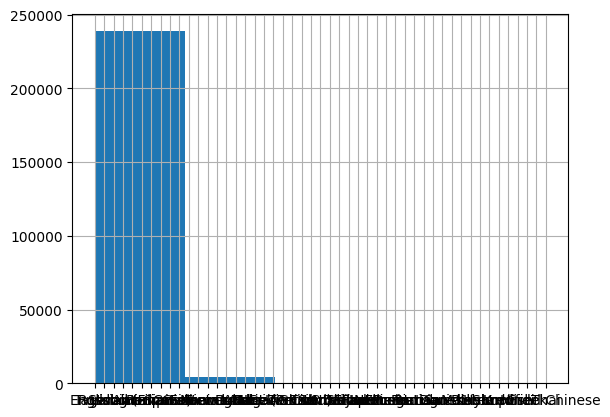

In [8]:
# isnpect distribution of languages

data_target_1['language'].hist(bins = 5);

<Axes: >

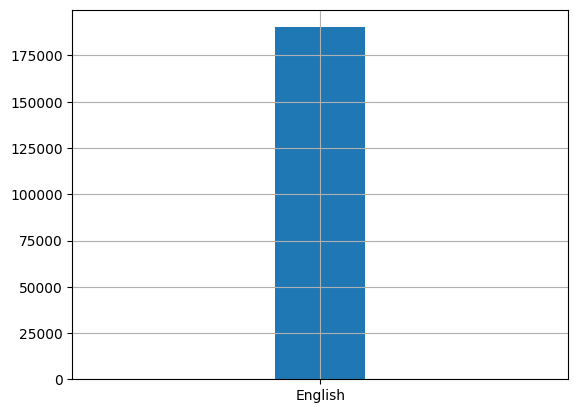

In [9]:
# Select only english tweets

data_target_11 = data_target_1[data_target_1['language'] == 'English']

data_target_11['language'].hist(bins = 5)

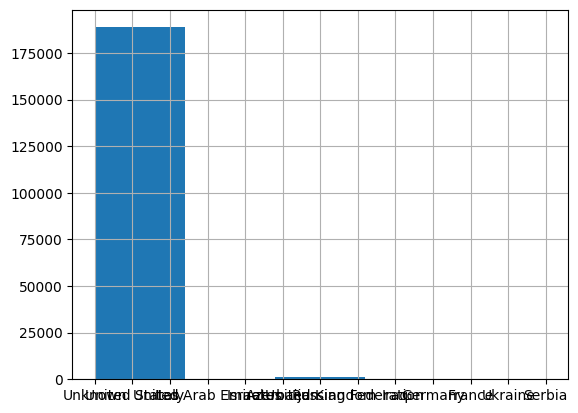

In [11]:
# inspect regional distribution

data_target_11['region'].hist(bins = 5);
data_target_11 = data_target_11.drop('region', axis = 1)

In [13]:
#inspect account type and categories

print(data_target_11.account_type.unique(), sep = ', ')
print('Account category:')
print(data_target_11.account_category.unique(), sep = ', ')

['Right' 'Koch' 'Italian' 'Russian' 'Left' '?' 'German' 'Hashtager'
 'Arabic' 'local' 'Commercial' 'French']
Account category:
['RightTroll' 'Fearmonger' 'NonEnglish' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


In [79]:
#inspect sample content

print(data_control_2.content.unique(), sep = ', ')

['im getting on borderlands and i will murder you all ,'
 'I am coming to the borders and I will kill you all,'
 'im getting on borderlands and i will kill you all,' ...
 'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice'
 'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I have no fucking idea how I ever didn ’ t notice'
 'Just like the windows partition of my Mac is like 6 years behind on its drivers So you have no idea how I didn’t notice']


## 3. Preliminary NLP

In [16]:
# import re and string 
import re
import string



# import spaCy and spacy stopwords in english to perform nlp
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy.lang.en.stop_words import STOP_WORDS

#import networkx for graph analysis

import networkx as nx



# define default nlp
nlp = spacy.blank("en")


In [17]:
'''Pre-process text'''


# function that takes a data frame and removes links (potential malware), punctuation and stopwords
def Preprocessor(df):
    output = df.copy(deep = True)
    
    # 1. Remove URL's and punctuation
    tokys = []
    for j in range(0, len(df["content"])):

        
        txt = df["content"][j]
      

        # remove punctuation and stop words
        
        txt = txt.lower()                          # set lower case
        txt = txt.replace('.', '')
        txt = txt.replace('#', '')                  # remove hashtags
        txt = re.sub(r'http\S+', '', txt )          # remove URL
        tokens = [token.text for token in nlp(txt)]

        # remove stopwords and short words
        tokens = [t for t in tokens if 
                  t not in STOP_WORDS and         
             t not in string.punctuation and
                 len(t) > 3]
        

        out_tokens = " ".join(tokens)
        tokys.append(out_tokens)
    output['tokens'] = tokys    # cleaned text tokens

    return output


In [23]:
# correct index of target data frame

index = range(len(data_target_11))
data_target_12 = data_target_11[data_target_11.content.notnull()].copy(deep=True)
data_target_12 = data_target_12.reset_index(drop = True)

In [24]:
# correct index of control data frame

index = range(len(data_control_2))
data_control_2 = data_control_2[data_control_2.content.notnull()].copy(deep=True)
data_control_2 = data_control_2.reset_index(drop = True)

In [25]:
# Preprocess the text suing the above function
## select part of data to be used - 33% russian propagators, 66% control 

data_target_proc_1 = Preprocessor(data_target_12[0:1500])
data_control_proc_1 = Preprocessor(data_control_2[0:3000])

In [26]:
# Merge Data Frames and assign prediction labels

data_merge_proc_1 = pd.DataFrame()
txt = []
labels = []
for i in range(0,int(len(data_target_proc_1)+len(data_control_proc_1))):
    if i <= len(data_target_proc_1):
        txt.append(data_target_proc_1.tokens[i])
        labels.append( 1)
    elif i > int(len(data_target_proc_1):
        txt.append(data_control_proc_1.tokens[i-len(data_target_proc_1)])
        labels.append( 0)

data_merge_proc_1['tokens'] = txt
data_merge_proc_1['label'] = labels

In [77]:
# Inspect merged Data Frame

data_merge_proc_1.iloc[1400]

tokens    agawam woman accidentally shot face police fil...
label                                                     1
Name: 1400, dtype: object

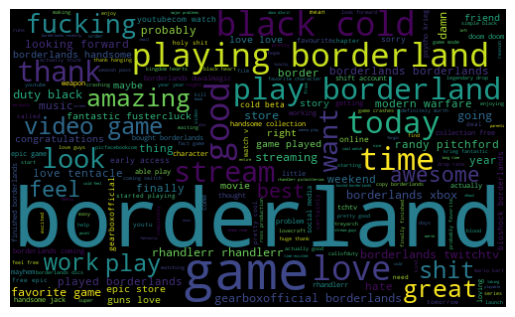

In [78]:
from wordcloud import WordCloud
from tqdm import tqdm

## plot word Cloud to inspect common words in the tweet data

allWords=' '.join([twts for twts in data_control_proc_1.tokens])
wordCloud=WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear' )
plt.axis('off')
plt.show()

## 4. Create Knowledge Graphs

In [31]:
# load pretrained spacy english-model

spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.8 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### This section is based on work by P. Sanagapati [8]

In [32]:
'''Sort for entities in the text - representing the garph nodes'''

nlp2 = spacy.load("en_core_web_sm")    # define new spacy nlp

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp2(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
        
        
      # check: token is a compound word or not
        if tok.dep_ == "compound":
            prefix = tok.text
          
        
        # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

      ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [33]:
# test entity function
print(data_merge_proc_1.tokens[2])
print()
get_entities(data_merge_proc_1.tokens[2])

['burns packers', 'gear boycottnfl']

In [34]:
'''Find all entity pairs'''

entity_pairs = []

for i in tqdm(data_merge_proc_1.tokens):
  entity_pairs.append(get_entities(i))

print(entity_pairs[0:1])

100%|██████████| 4500/4500 [00:06<00:00, 673.89it/s]


In [35]:
'''Sort for connecting words in the text using pattern matching - i.e edges'''

# function to identify relating words in an input document
def get_relation(sent):

  doc = nlp2(sent)

  # Matcher class object 
  matcher = Matcher(nlp2.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",  [pattern]) 

  # avoid breaking if no relating words are found
  matches = matcher(doc)
  if len(matches) > 0:
      k = len(matches) - 1

      span = doc[matches[k][1]:matches[k][2]] 
      return(span.text)
  # assigns empty string if no word is found
  else:
      return ''

In [39]:
# test get_relation function

print(data_target_proc_1.tokens[0])
print()
get_relation(data_target_proc_1.tokens[0])

'heard'

In [36]:
'''Find all relating words'''

relations = [get_relation(i) for i in tqdm(data_merge_proc_1.tokens)]
print(relations[0])

100%|██████████| 4500/4500 [00:06<00:00, 655.91it/s]


In [44]:
#inspect most common types of relating words

pd.Series(relations).value_counts()[:5]

@realdonaldtrump    14
                     6
says                 6
remember             5
crowd                4
Name: count, dtype: int64

In [81]:
'''Create Knowledge Graph for all text'''

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

# data set for graph ccreation

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

/Users/valentinwalischewski/anaconda3/envs/SL/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


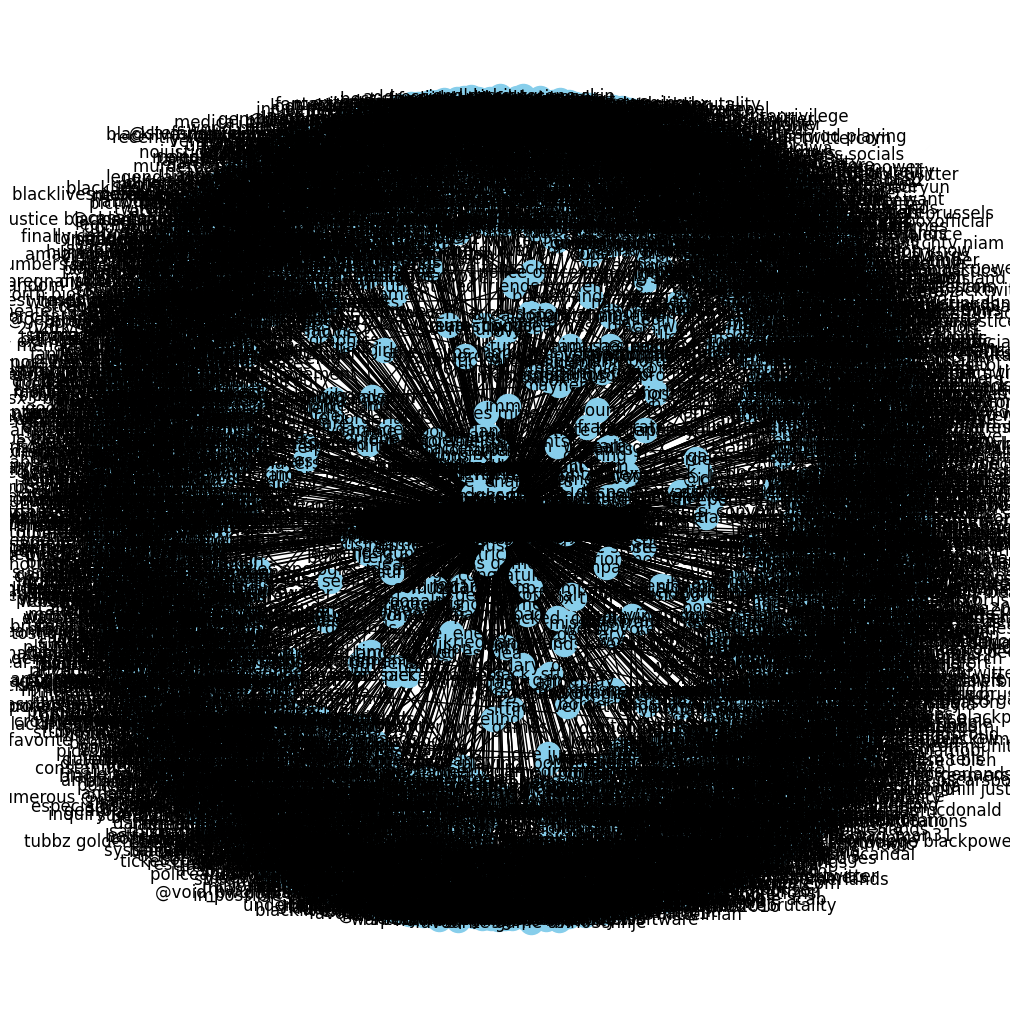

In [83]:
# create a directed-graph from dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

# plot graph
plt.figure(figsize=(10,10))


t = G
pos = nx.spring_layout(t)
nx.draw(t, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [39]:
'''Calculate the betweenness centrality for every node'''

# using networkx's inbuilt nx.edge_betweenness_centrality() function

I_G = nx.edge_betweenness_centrality(G)

In [40]:
# get list of knowledge graph nodes

Nodes = list(G.nodes())

In [41]:
'''Function to create knowledge graph's for all individual tweets'''

# takes subject and object lists and creates a knowledge graph
def make_KG(ents, relation):
    
    entity_pairs = ents
    relations = relation
    
    if len(entity_pairs[0]) > 0 and len(entity_pairs[1]) > 0:   # ensure there are nodes for the respective user
        
        source = [entity_pairs[0]]
        target = [entity_pairs[1]]
        
        kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
        
        # create graph
        
        G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
    else:
        G = nx.empty_graph(0, create_using=nx.DiGraph)    #otherwise output an empty graph

    ########################################################################################
    
    return G



In [42]:
'''create KG's for all individual tweets'''


collect_kg = []

for i in range(len(data_merge_proc_1.tokens)):
    collect_kg.append(make_KG(entity_pairs[i], relations[i]))



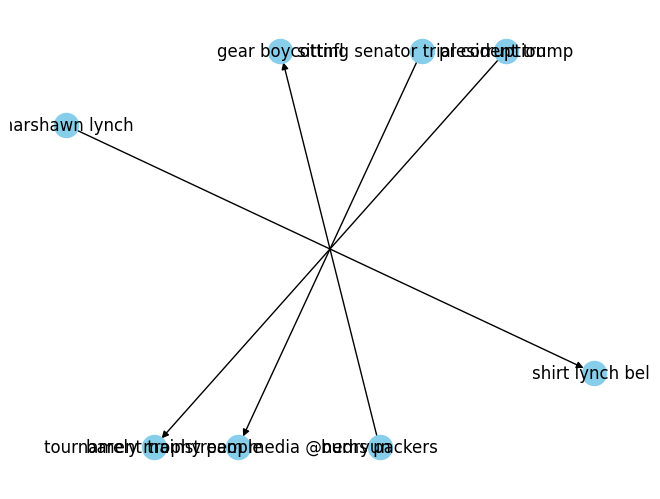

In [143]:
# plot a few example KG's

for i in collect_kg[0:4]:
    pos = nx.spring_layout(i)
    nx.draw(i, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos);


## 5. Create Resonance Graph

In [43]:
# collect user nodes
user_nodes = {}
for i in range(len(data_merge_proc_1.tokens)):
    user_nodes[i] = list(collect_kg[i].nodes)

In [45]:
# collect user pairs sharing nodes and shared nodes
user_pairs = []
common_nodes = []
for i in range(len(data_merge_proc_1.tokens)):
    for j in range(len(data_merge_proc_1.tokens)):
        if len(user_nodes[i]) != 0 and len(user_nodes[i]) != 0 and len(user_nodes[i]) == len(user_nodes[j]) and i != j:
            
            if user_nodes[i][0] == user_nodes[j][0]:
                user_pairs.append([i, j])
                common_nodes.append(user_nodes[i])
            elif len(user_nodes[i]) > 1 and len(user_nodes[j]) > 1 and user_nodes[i][1] == user_nodes[j][1]:
                user_pairs.append([i, j])
                common_nodes.append(user_nodes[i])

In [46]:
'''calculate edge betweenness centralities and create resonance matrix'''

# define resonance matrix
WR_AB = np.zeros((len(data_merge_proc_1.tokens), len(data_merge_proc_1.tokens)))
for i in range(len(data_merge_proc_1.tokens)):
    for j in range(len(data_merge_proc_1.tokens)):
        W = 0
        for p in user_pairs:
            # find nodes that are shared by users
            if [i, j] == p:
                
                ind = user_pairs.index([i, j])
                c_nodes_A = user_nodes[i]
                c_nodes_B = user_nodes[j]
               
                try:
                    I_A = I_G[(c_nodes_A[0], c_nodes_A[1], 0)]
                    I_B = I_G[(c_nodes_B[0], c_nodes_B[1], 0)]
                    
                   
                    # calculate normalized resonance
                   
                    W += I_A*I_B/np.sqrt((I_A**2)*(I_B**2))
                    
                except:
                    W += 0
                
                
            elif i == j:
                W += 0
                
            else:
                W += 0 
            # populate resonace matrix
            WR_AB[i, j] = W


In [87]:
# make adjacency_matrix based on threshold method
A = np.zeros(WR_AB.shape)
for i in range(len(data_target_proc_1.tokens)):
    for j in range(len(data_target_proc_1.tokens)):
        if WR_AB[i, j] > 0.01:
            A[i, j] = 1
        else:
            A[i, j] = 0

In [88]:
# create resonance graph from standardized resonance matrix

temp = nx.MultiGraph()
G2 = nx.from_numpy_array(A, parallel_edges = True, create_using = temp)

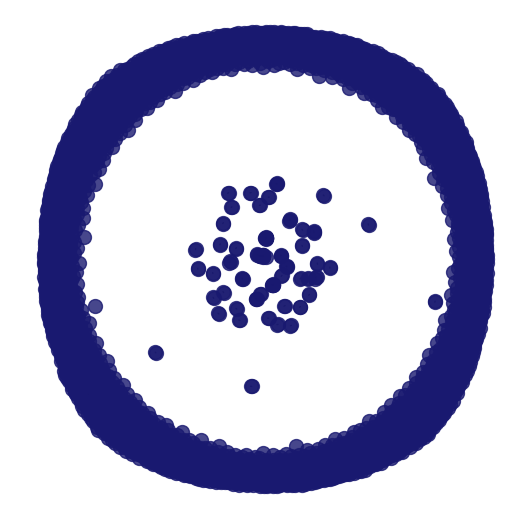

In [89]:
# Plot resonance graph

plt.figure(figsize=(5,5))


t = G2
pos = nx.spring_layout(t)
nx.draw(t, with_labels=False, node_color='midnightblue', edge_cmap=plt.cm.Blues, pos = pos, alpha = 0.8, node_size = 100)
plt.show()

## 6. Community Detection

In [90]:
'''Community Detection using Girvan Newman algorithm'''

# using networkx's inbuilt nx.community.girvan_newman() implementation

communities = list(nx.community.girvan_newman(G2))

In [91]:
# discard single member communities

communities_sorted = []
for i in communities:
    for j in i:
        if len(j) >1:
            communities_sorted.append(j)

In [92]:
# filter unique communities to avoid double counting

comms_unique = list(set([frozenset(c) for c in communities_sorted]))
print('There were ' + str(len(comms_unique)) + ' unique communities identified')

There were 92 unique communities identified


In [93]:
# create color map for visualization


# get node indxs for the communities
comm_indxs = []
for comm in comms_unique[1:]:
    comm = list(comm)
    for i in comm:
        comm_indxs.append(i)

# fill out the colormap list
colormap_G2 = []

for node in G2.nodes:
    if node in comm_indxs:
        colormap_G2.append('y')      # detected in a community
    elif data_merge_proc_1.label[node] == 1:
        colormap_G2.append('r')       # russian propagator-undetected
    else:
        colormap_G2.append('b')        # control
        


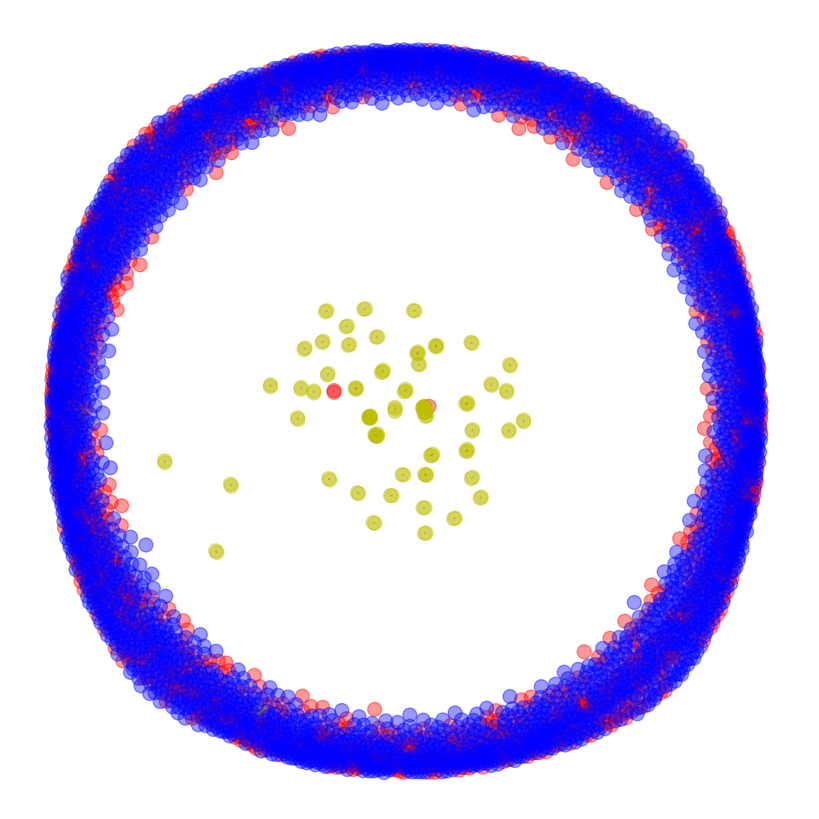

In [94]:
# Visualize Identified communities

plt.figure(figsize=(8,8))

pos = nx.spring_layout(G2)
nx.draw(G2, pos, node_color=colormap_G2, edge_color = 'k',with_labels=False, node_size = 100, alpha = 0.4)

## 7. Propagator Classification

In [100]:

# import node2vec and word2vec model implementations


from node2vec import Node2Vec
from gensim.models import Word2Vec


In [101]:
# Fit node2vec model on the resonance graph using local CPU

node2vec = Node2Vec(G2, dimensions=128, walk_length=40, num_walks=100, workers=2)
model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/4500 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 98.88it/s]


In [102]:
# get 128 dimensional node embeddings

node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors

In [111]:
'''Set up for Graph Convolutional Network'''

# import relevant pytorch functions
import torch_geometric.transforms as T
from torch_geometric.utils.convert import from_networkx
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch

# convert networkx graph tp pytorch graph


graph = from_networkx(G2)

# add feature embeddings
graph.x = torch.from_numpy(node_embeddings)

# add targets - 1, 0 - propagator, no propagator
labs = np.array(data_merge_proc_1.label)
graph.y = torch.from_numpy(labs)

# spplit into test, train and validation sets
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

### This section is based on work by T. Masui [9]

In [120]:
'''Define training and evaluation function'''

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=2000):
    step_loss = []

    for epoch in range(1, n_epochs + 1):
        # update model and calculate output
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        
        # calculate loss
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        step_loss.append(loss)

        # backwards propagate
        loss.backward()
        optimizer.step()

        # evaluate current model
        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        # print status statement
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')
     #####################################################################################
    
    return model, step_loss

def eval_node_classifier(model, graph, mask):
    
    model.eval()
    # get model predictions for test data
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    # calculate accuracy
    acc = int(correct) / int(mask.sum())

    return acc

In [121]:
'''Define The GCN using torch_geometric'''

class GCN(torch.nn.Module):
    # define the GCN layers
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(graph.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)
    #define forward pass
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)
    
        return output
    
#initialize model
gcn = GCN()
# set up optimizer
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)

# define loss function
criterion = nn.CrossEntropyLoss()

# train the model
gcn, gcn_losses = train_node_classifier(gcn, graph, optimizer_gcn, criterion)



Epoch: 010, Train Loss: 0.593, Val Acc: 0.693
Epoch: 020, Train Loss: 0.596, Val Acc: 0.693
Epoch: 030, Train Loss: 0.591, Val Acc: 0.693
Epoch: 040, Train Loss: 0.589, Val Acc: 0.693
Epoch: 050, Train Loss: 0.588, Val Acc: 0.693
Epoch: 060, Train Loss: 0.586, Val Acc: 0.693
Epoch: 070, Train Loss: 0.585, Val Acc: 0.693
Epoch: 080, Train Loss: 0.583, Val Acc: 0.693
Epoch: 090, Train Loss: 0.582, Val Acc: 0.693
Epoch: 100, Train Loss: 0.580, Val Acc: 0.693
Epoch: 110, Train Loss: 0.578, Val Acc: 0.693
Epoch: 120, Train Loss: 0.577, Val Acc: 0.693
Epoch: 130, Train Loss: 0.575, Val Acc: 0.693
Epoch: 140, Train Loss: 0.574, Val Acc: 0.693
Epoch: 150, Train Loss: 0.573, Val Acc: 0.693
Epoch: 160, Train Loss: 0.572, Val Acc: 0.693
Epoch: 170, Train Loss: 0.571, Val Acc: 0.693
Epoch: 180, Train Loss: 0.570, Val Acc: 0.693
Epoch: 190, Train Loss: 0.569, Val Acc: 0.693
Epoch: 200, Train Loss: 0.568, Val Acc: 0.693
Epoch: 210, Train Loss: 0.567, Val Acc: 0.693
Epoch: 220, Train Loss: 0.566, Val

In [132]:
# collect loss per iteration for learning visualization
losses = []
for i in gcn_losses:
    losses.append(i.detach().numpy())

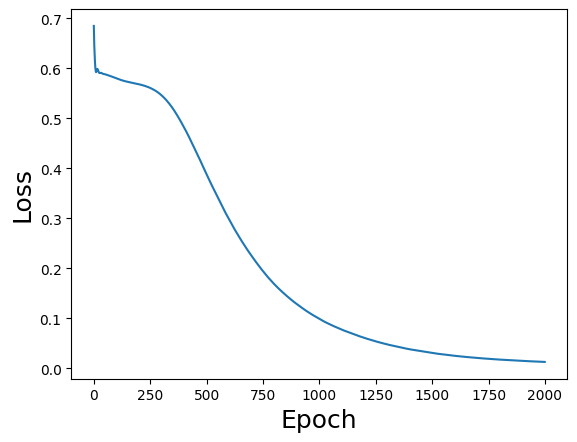

In [136]:
'''Plot the models loss curve'''

plt.plot(losses)
plt.xlabel("Epoch", fontsize = 18)
plt.ylabel("Loss", fontsize = 18);

In [137]:
'''Calculate test accuracy'''

test_acc = eval_node_classifier(gcn, graph, graph.test_mask) #use pre defined evaluation function
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.601


In [138]:
'''Print model summary'''

#using torch_summary for easy model architecture visualization
from torchsummary import summary
print(summary(gcn))


Layer (type:depth-idx)                   Param #
├─GCNConv: 1-1                           --
|    └─SumAggregation: 2-1               --
|    └─Linear: 2-2                       2,048
├─GCNConv: 1-2                           --
|    └─SumAggregation: 2-3               --
|    └─Linear: 2-4                       32
Total params: 2,080
Trainable params: 2,080
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─GCNConv: 1-1                           --
|    └─SumAggregation: 2-1               --
|    └─Linear: 2-2                       2,048
├─GCNConv: 1-2                           --
|    └─SumAggregation: 2-3               --
|    └─Linear: 2-4                       32
Total params: 2,080
Trainable params: 2,080
Non-trainable params: 0


## References

[8] P. Sanagapati, "Knowledge Graph & NLP Tutorial-(BERT,spaCy,NLTK)", Kaggle, 2021, https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

[9] T. Masui, "Graph Neural Networks with PyG on Node Classification, Link Prediction, and Anomaly Detection", Medium, (originally published on Towards Data Science), 06.10.2022, https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275
